# Wine Quality Prediction Analysis

## Introduction
In this notebook, we will perform a comprehensive analysis to predict wine quality based on various features such as physicochemical properties, grape types, and winery information.

We will follow these main steps:
1. **Data Exploratory Analysis & Unsupervised Exploration**: Understanding the data distribution, correlations, and potential natural groupings.
2. **Data Preprocessing**: Cleaning the data, handling missing values, encoding categorical variables, and preparing train/test splits.
3. **Baseline Modeling**: Establishing baseline results using Linear Regression and Ensemble methods (Random Forest).

In [63]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [64]:
# Load Data
try:
    df = pd.read_csv('data/all_wines.csv')
    print("Data loaded successfully!")
    
    # Drop rows without ratings or with rating = 0
    initial_shape = df.shape
    df = df.dropna(subset=['rating'])
    df = df.drop_duplicates()
    df = df[df['rating'] != 0]
    print(f"Dropped {initial_shape[0] - df.shape[0]} rows without ratings or with rating = 0.")
    
    display(df.head())
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: File not found. Please check the path 'data/25-11-2025.csv'")

    df.describe()

Data loaded successfully!
Dropped 934 rows without ratings or with rating = 0.


,id,name,vintage,country,winery,grapes,rating,price,acidity,intensity,sweetness,tannin,flavor_rank1,flavor_rank2,flavor_rank3
0,1232441,Château Roquefort Bordeaux Rouge 2008,2008,France,Château Roquefort,Cabernet Sauvignon;Cabernet franc;Malbec;Merlo...,3.7,5.0,3.779062,3.958017,1.510457,3.602762,black_fruit,earth,oak
1,1196114,Nadau Château Gillet Bordeaux Rouge 2019,2019,France,Nadau,Cabernet Sauvignon;Cabernet franc;Malbec;Merlo...,3.5,4.9,3.672749,3.710543,1.473961,3.512615,black_fruit,oak,red_fruit
2,1222364,Château Gravelier Bordeaux Rouge 2022,2022,France,Château Gravelier,Cabernet Sauvignon;Cabernet franc;Malbec;Merlo...,3.4,4.9,3.847436,3.892167,1.678449,3.283518,red_fruit,oak,black_fruit
3,1195299,Les Hauts de Palette Château Haut-Mondain Bord...,2016,France,Les Hauts de Palette,Cabernet Sauvignon;Cabernet franc;Malbec;Merlo...,3.4,4.9,3.627296,3.664513,1.638803,3.364282,oak,black_fruit,spices
4,1183224,Château des Léotins Bordeaux Rouge 2023,2023,France,Château des Léotins,Cabernet Sauvignon;Cabernet franc;Malbec;Merlo...,3.3,4.5,3.876773,3.579522,1.343426,3.439363,black_fruit,oak,earth


Dataset shape: (23506, 15)


## 1. Data Exploratory Analysis & Unsupervised Exploration
Understanding the data distribution, correlations, and potential natural groupings.

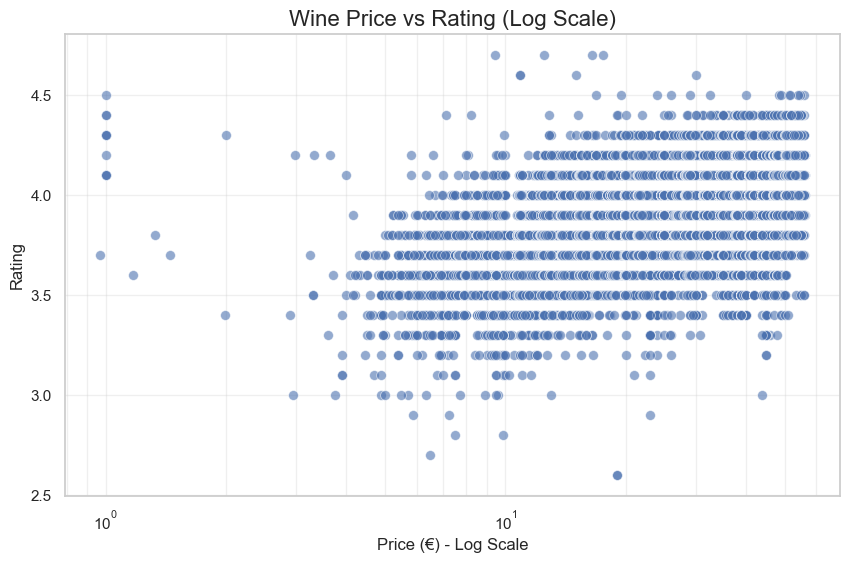

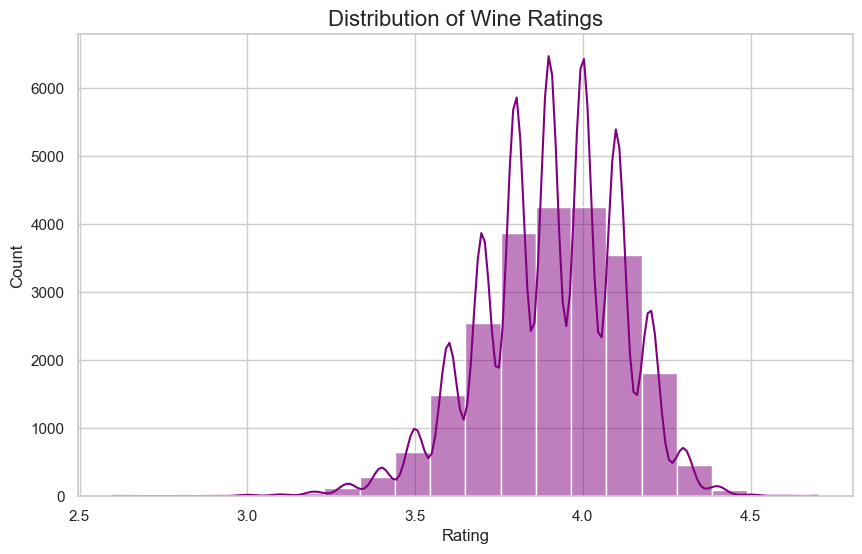

/var/folders/5b/jc63st1556573ds_nhhwtgpm0000gn/T/ipykernel_65726/304049305.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['country'].isin(top_countries)], x='country', y='price', palette='Set3')


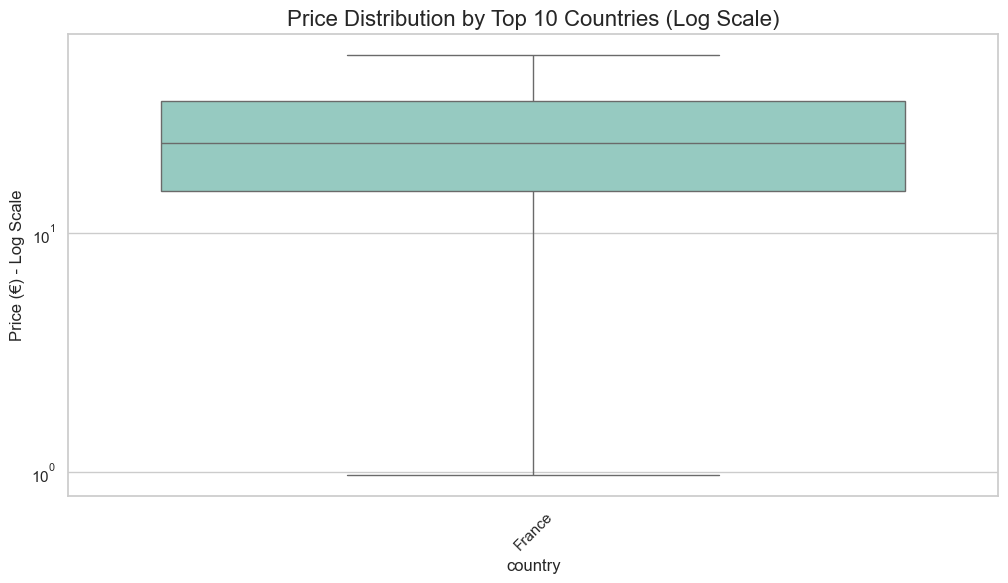

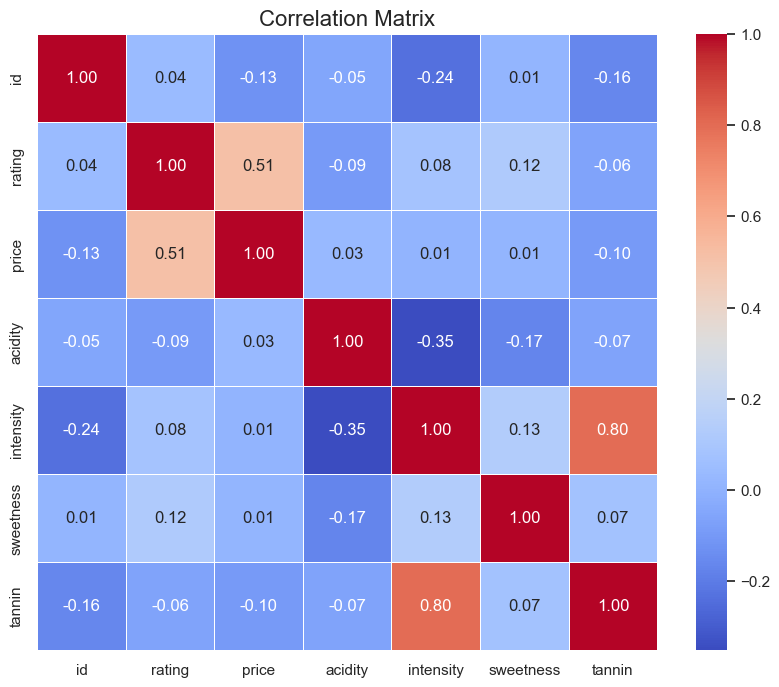

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 23506 entries, 0 to 24439
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            23506 non-null  int64  
 1   name          23506 non-null  object 
 2   vintage       23504 non-null  object 
 3   country       23506 non-null  object 
 4   winery        23504 non-null  object 
 5   grapes        21575 non-null  object 
 6   rating        23506 non-null  float64
 7   price         23506 non-null  float64
 8   acidity       23346 non-null  float64
 9   intensity     23346 non-null  float64
 10  sweetness     23346 non-null  float64
 11  tannin        23342 non-null  float64
 12  flavor_rank1  21953 non-null  object 
 13  flavor_rank2  21491 non-null  object 
 14  flavor_rank3  21060 non-null  object 
dtypes: float64(6), int64(1), object(8)
memory usage: 2.9+ MB

Dataset Description:


,id,rating,price,acidity,intensity,sweetness,tannin
count,2.350600e+04,23506.000000,23506.000000,23346.000000,23346.000000,23346.000000,23342.000000
mean,2.768399e+06,3.901982,25.954429,3.766053,3.547502,1.551895,3.298898
std,2.758092e+06,0.206364,12.803297,0.422438,0.789067,0.280902,0.692285
min,1.058000e+03,2.600000,0.970000,2.159869,1.000000,1.000000,1.235593
25%,1.174765e+06,3.800000,15.000000,3.439752,3.000000,1.396342,2.916372
50%,1.571556e+06,3.900000,24.000000,3.775000,3.843210,1.544965,3.444620
75%,3.435882e+06,4.100000,36.000000,4.086065,4.123977,1.694003,3.775717
max,1.343534e+07,4.700000,56.200000,5.000000,5.000000,3.149077,5.000000


In [65]:
# EDA: Visualizations

# 1. Price vs Rating scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='price', y='rating', alpha=0.6, s=50)
plt.xscale('log')
plt.title('Wine Price vs Rating (Log Scale)', fontsize=16)
plt.xlabel('Price (€) - Log Scale', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.grid(alpha=0.3, which='both')
plt.show()

# 2. Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=20, kde=True, color='purple')
plt.title('Distribution of Wine Ratings', fontsize=16)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# 3. Box Plot: Price distribution by Top 10 Countries
top_countries = df['country'].value_counts().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['country'].isin(top_countries)], x='country', y='price', palette='Set3')
plt.yscale('log') # Log scale for price as it varies a lot
plt.title('Price Distribution by Top 10 Countries (Log Scale)', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Price (€) - Log Scale')
plt.show()

# 4. Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

print("Dataset Info:")
df.info()
print("\nDataset Description:")
display(df.describe())

### Unsupervised Exploration: K-Means Clustering
We will now perform K-Means clustering to identify potential natural groupings of wines based on their physicochemical properties and price/rating. This can help us understand if there are distinct "types" of wines in our dataset beyond just the varietal or region.

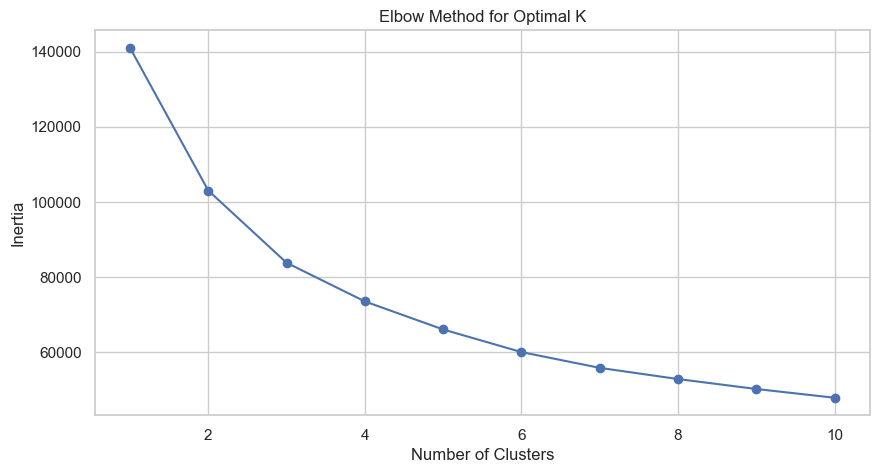

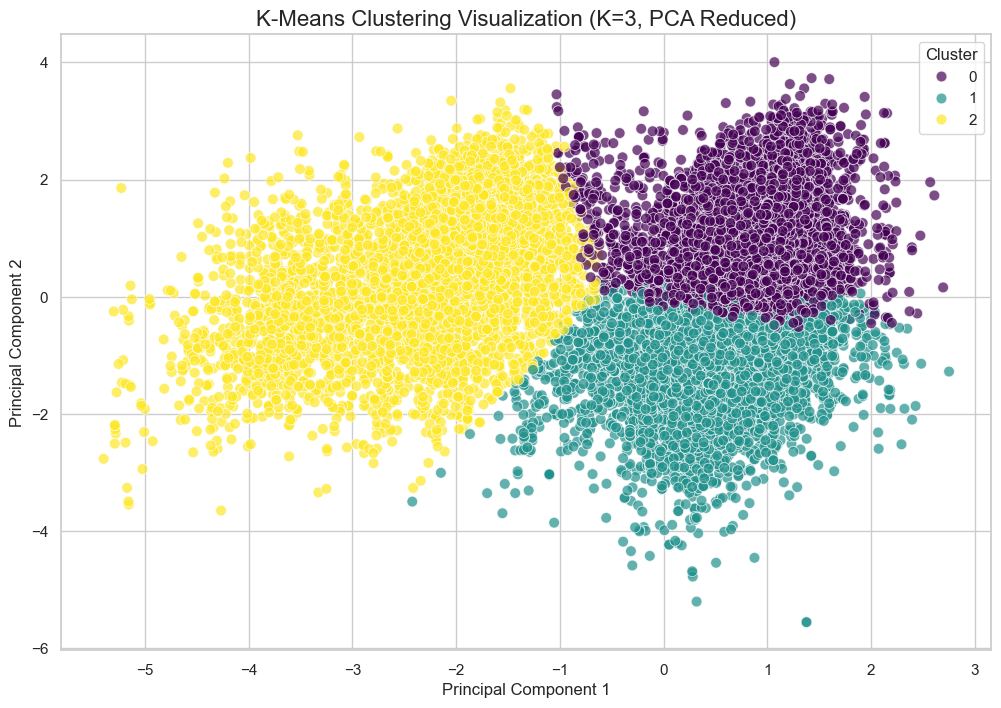

Cluster Centers (Mean Values):


,price,rating,acidity,intensity,sweetness,tannin
cluster,,,,,,
0,34.874800,4.049729,3.635861,4.023960,1.626650,3.608145
1,15.832048,3.761653,3.700473,3.810006,1.545260,3.612973
2,30.467463,3.927704,4.080108,2.358154,1.450324,2.271662


/var/folders/5b/jc63st1556573ds_nhhwtgpm0000gn/T/ipykernel_65726/383235033.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=df, palette='viridis')
/var/folders/5b/jc63st1556573ds_nhhwtgpm0000gn/T/ipykernel_65726/383235033.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=df, palette='viridis')
/var/folders/5b/jc63st1556573ds_nhhwtgpm0000gn/T/ipykernel_65726/383235033.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=df, palette='viridis')
/var/folders/5b/jc6

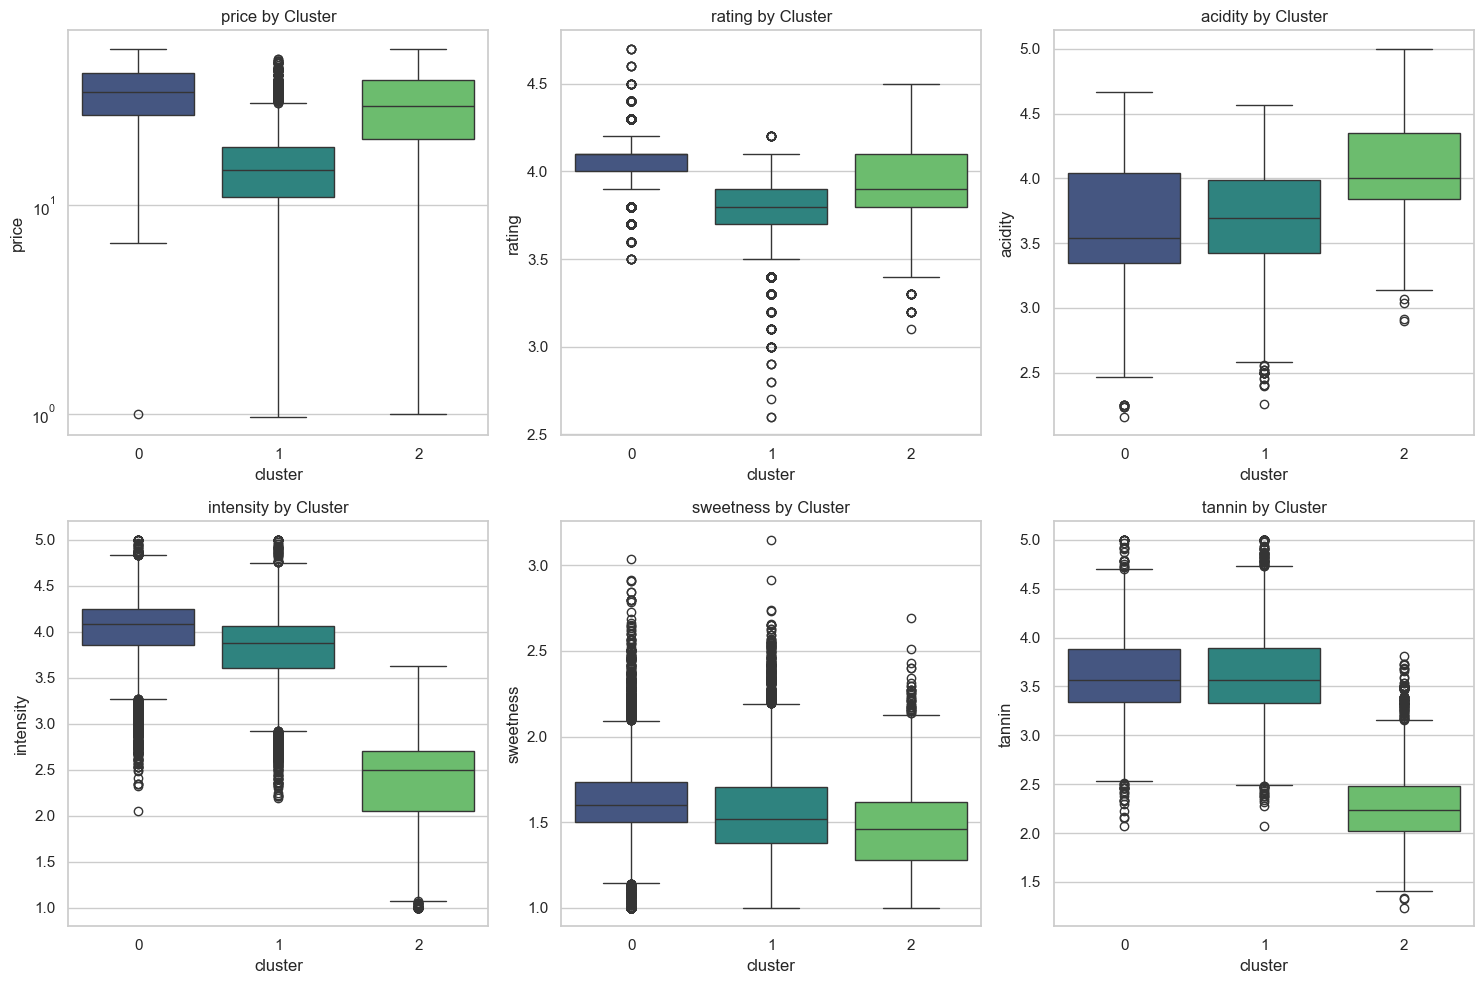

In [66]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# --- Unsupervised Exploration: K-Means Clustering ---

# 1. Select features for clustering
# We focus on numeric features that define the wine's profile
cluster_features = ['price', 'rating', 'acidity', 'intensity', 'sweetness', 'tannin']
# Filter to ensure we only use rows where these columns are not null (or impute them)
X_cluster = df[cluster_features].copy()

# 2. Preprocessing for Clustering
# Impute missing values
imputer = SimpleImputer(strategy='median')
X_cluster_imputed = imputer.fit_transform(X_cluster)

# Scale features (critical for K-Means)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster_imputed)

# 3. Determine Optimal K (Elbow Method)
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# 4. Apply K-Means (Let's choose K=3 for this example)
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster_scaled)

# Add cluster labels to the dataframe
df['cluster'] = clusters

# 5. Visualize Clusters using PCA (2D projection)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_cluster_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='viridis', s=60, alpha=0.7)
plt.title(f'K-Means Clustering Visualization (K={k_optimal}, PCA Reduced)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# 6. Analyze Cluster Characteristics
print("Cluster Centers (Mean Values):")
cluster_summary = df[cluster_features + ['cluster']].groupby('cluster').mean()
display(cluster_summary)

# Boxplots for interpretation
plt.figure(figsize=(15, 10))
for i, col in enumerate(cluster_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='cluster', y=col, data=df, palette='viridis')
    plt.title(f'{col} by Cluster')
    if col == 'price':
        plt.yscale('log')
plt.tight_layout()
plt.show()

## 2. Data Preprocessing
Cleaning the data, handling missing values, encoding categorical variables, and preparing train/test splits.

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

# --- 1. Définition des fonctions utilitaires ---
def split_semicolon(text):
    """Fonction de tokenization pour CountVectorizer"""
    # Séparer par point-virgule et nettoyer les espaces
    return [x.strip() for x in text.split(';')]

# --- 2. Préparation des données (Target vs Features) ---
# On retire la target ('rating') et les identifiants inutiles
X = df.drop(['rating', 'id', 'name'], axis=1)
y = df['rating']

# Conversion de la colonne vintage en numérique (gestion des 'N.V.')
X['vintage'] = pd.to_numeric(X['vintage'], errors='coerce')

# --- 3. Définition des groupes de features ---
numeric_features = ['vintage', 'price', 'acidity', 'intensity', 'sweetness', 'tannin']
# Note : 'grapes' est retiré des categorical car il a son propre traitement
categorical_features = ['country', 'winery', 'flavor_rank1', 'flavor_rank2', 'flavor_rank3']
grapes_feature = ['grapes']

# --- 4. Création des Transformers ---

# Pipeline Numérique : Imputation médiane + Standardisation
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline Catégoriel (Classique) : Imputation 'missing' + OneHot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=20))
])

# Pipeline Raisins (Spécial) : Imputation '0' + Flatten + CountVectorizer
# 1. Imputer (Remplissage des valeurs manquantes)
# 2. Flatten (Aplatissement des données)
# 3. CountVectorizer (Extraction des cépages)
grapes_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='0')),
    ('flatten', FunctionTransformer(lambda x: np.reshape(x, -1), feature_names_out='one-to-one')),
    ('vectorizer', CountVectorizer(
        tokenizer=split_semicolon, 
        token_pattern=None, 
        binary=True, 
    ))
])

# --- 5. Assemblage du Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('grapes', grapes_transformer, grapes_feature)
    ])

# --- 6. Split Train/Test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 7. Application du Preprocessing ---
# Fit sur le train set uniquement pour éviter le data leakage
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# --- 8. Vérification des résultats ---
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

try:
    # Affichage des features générées pour vérifier que les raisins sont bien là
    feature_names = preprocessor.get_feature_names_out()
    print(f"\nExemple de features générées ({len(feature_names)} total) :")
    print(feature_names[:10]) # Affiche les 10 premières
    # Cherche quelques features de raisins pour confirmer
    grape_cols = [f for f in feature_names if 'grapes__' in f]
    print(f"\nNombre de features 'grapes' détectées : {len(grape_cols)}")
    print("Exemple de cépages :", grape_cols[:7])
except Exception as e:
    print(f"Erreur lors de l'extraction des noms de features : {e}")


Training data shape: (18804, 96)
Test data shape: (4702, 96)

Exemple de features générées (96 total) :
['num__vintage' 'num__price' 'num__acidity' 'num__intensity'
 'num__sweetness' 'num__tannin' 'cat__country_France'
 'cat__winery_Bouchard Père & Fils' 'cat__winery_Château Chasse-Spleen'
 'cat__winery_Château Grand Corbin-Despagne']

Nombre de features 'grapes' détectées : 27
Exemple de cépages : ['grapes__0', 'grapes__cabernet franc', 'grapes__cabernet sauvignon', 'grapes__carignan', 'grapes__carménère', 'grapes__cinsaut', 'grapes__counoise']


## 3. Baseline Modeling
Establishing baseline results using Linear Regression and Ensemble methods (Random Forest).

In [68]:
# Baseline Models

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation
# Calculate RMSE manually as 'squared' parameter might not be supported in this version
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Linear Regression RMSE:", rmse_lr)
print("Random Forest RMSE:", rmse_rf)

print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

Linear Regression RMSE: 0.16669803675928965
Random Forest RMSE: 0.14621026267893836
Linear Regression R2: 0.3443395173752154
Random Forest R2: 0.4956015380485418


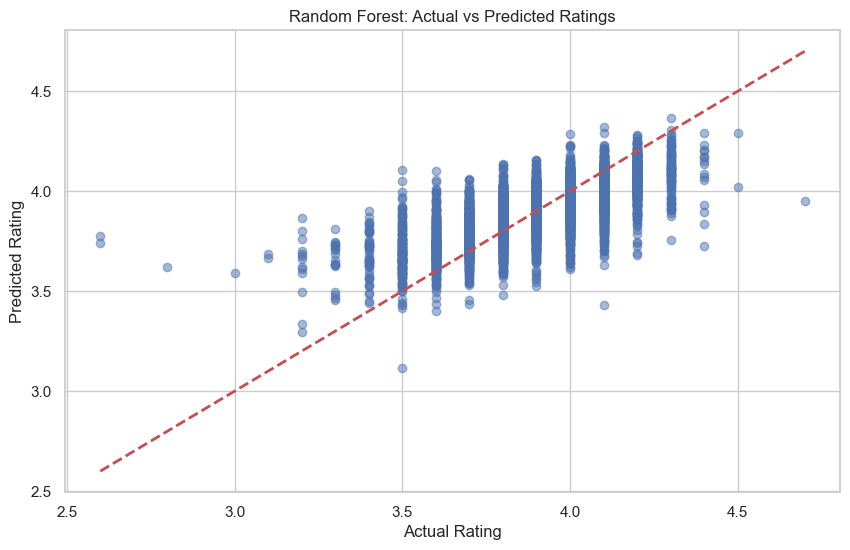

/var/folders/5b/jc63st1556573ds_nhhwtgpm0000gn/T/ipykernel_65726/3155697545.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


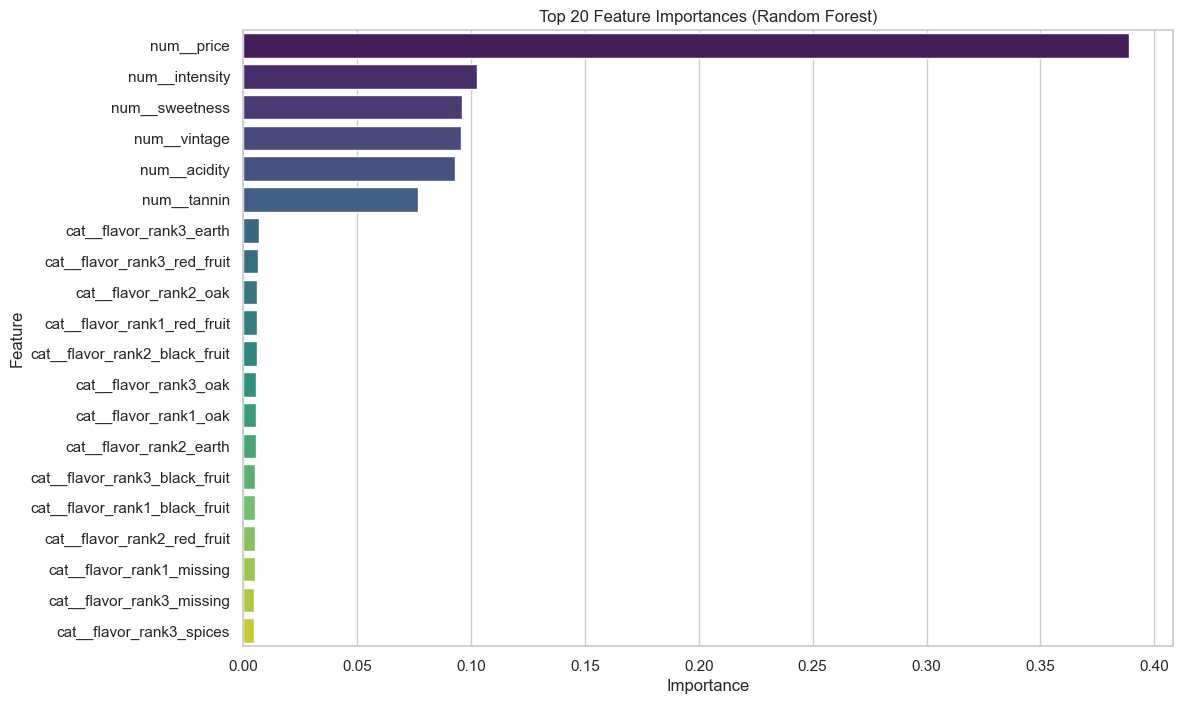

In [69]:
# Visualizing Model Performance

# 1. Actual vs Predicted (Random Forest)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Random Forest: Actual vs Predicted Ratings')
plt.show()

# 2. Feature Importance (Random Forest)
# Get feature names from the preprocessor
feature_names = []
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    # Fallback for older sklearn versions or if get_feature_names_out is not available
    # This is a simplified fallback and might not be perfect
    feature_names = numeric_features + list(preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features))

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(20) # Top 20 features

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.show()